In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from loader.DataLoader import read_dataframe
from loader.DataTransformer import lag_list, transform_matrix
from torch import Tensor

In [2]:
# data parameter
LAG = 15

In [3]:
# prepare data
sequence = read_dataframe('all').to_numpy()
sequence = sequence[:, 1:]
# sequence = transform_matrix(sequence, 'DIFF')
# sequence = transform_matrix(sequence, 'NORM')
# sequence[np.isnan(sequence)] = 0 # fill na - there is a column which are all 0

shifted_sequence = lag_list(sequence, LAG + 1)  # shift into delayed sequences

x_train = shifted_sequence[:, :-1, 1:]  # for each delayed sequence, take all elements except last element
y_train = shifted_sequence[:, -1, -1]  # for each delayed sequence, only take the last element
y_train = y_train.reshape(-1, 1)

x_train = torch.from_numpy(x_train.astype('float64')).type(torch.Tensor)  # convert to tensor
y_train = torch.from_numpy(y_train.astype('float64')).type(torch.Tensor)  # convert to tensor

wave_1_x, wave_1_y = x_train[52 -LAG:103 -LAG], y_train[52 -LAG:103 -LAG]
wave_2_x, wave_2_y = x_train[160 -LAG:280 -LAG], y_train[160 -LAG:280 -LAG]
wave_3_x, wave_3_y = x_train[280 -LAG:505 -LAG], y_train[280 -LAG:505 -LAG]
wave_4_x, wave_4_y = x_train[757 -LAG:871 -LAG], y_train[757 -LAG:871 -LAG]

wave_x, wave_y = wave_3_x, wave_3_y

### LSTM Model

In [4]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, input_size):
        super(Attention, self).__init__()
        self.input_size = input_size
        
        self.query = nn.Linear(input_size, input_size)
        self.key = nn.Linear(input_size, input_size)
        self.value = nn.Linear(input_size, input_size)

    def forward(self, x, mask=None):
        # Transform inputs to query, key, value
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.input_size, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        weights = nn.functional.softmax(scores, dim=-1)

        # Compute weighted input
        output = torch.matmul(weights, V)
        
        return output, weights

class Attention_ResidualLstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0):
        super(Attention_ResidualLstmModel, self).__init__()
        self.feature_attention = Attention(input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.residual = nn.Linear(input_size, output_size)
        self.fc2 = nn.Linear(2, output_size)

    def forward(self, x):
        weighted_input, att_weights = self.feature_attention(x)  # Apply feature attention
        out, _ = self.lstm(weighted_input)
        out = self.fc(out[:, -1, :])
        residual = self.residual(x[:, -1, :]) # last timestamp of output only

        out = self.fc2(torch.cat((out, residual), dim=1))
        return out

In [5]:
class CurveLoss(nn.MSELoss):
    def __init__(self, model, lambda_l1, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)
        self.model = model
        self.lambda_l1 = lambda_l1

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        l1_penalty = 0
        for param in self.model.parameters():
            l1_penalty += torch.sum(torch.abs(param))
        return super().forward(input, target) + torch.square(torch.mean(torch.abs(input - target))) + self.lambda_l1 * l1_penalty

In [6]:
# build model
input_dim = x_train.shape[-1]
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 3_000

model = Attention_ResidualLstmModel(input_dim, hidden_dim, num_layers, output_dim)

In [7]:
# 2nd Attention Model
# wave_x, wave_y = wave_3_x, wave_3_y
# hidden_dim = 128
# num_layers = 4
# output_dim = 1
# num_epochs = 3_000

# 3rd Attention Model
# hidden_dim = 64
# num_layers = 4
# output_dim = 1
# num_epochs = 3_000

In [8]:
# train
# num_epochs = 1_000
# loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.L1Loss()
# loss_fn = torch.nn.SmoothL1Loss()
loss_fn = CurveLoss(model, 0)
# optimiser = torch.optim.Adam(model.parameters(), lr=3e-6)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
min_loss = np.inf
best_model_state = None
model.train()

TRAIN_RANGE = int(np.floor(wave_y.shape[0] * 3 / 4))

y_var = np.var(wave_y.numpy().reshape(-1)[:TRAIN_RANGE])
for epoch in range(1, num_epochs + 1):
    y_pred = model(wave_x[:TRAIN_RANGE])
    loss = loss_fn(y_pred, wave_y[:TRAIN_RANGE])
    if epoch % 100 == 0:
        print("Epoch: %d | MSE: %.2E | RRSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item() / y_var)))
    if min_loss > loss.item():
        best_model_state = copy.deepcopy(model.state_dict())
        min_loss = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch: 100 | MSE: 3.36E+04 | RRSE: 5.74E+00
Epoch: 200 | MSE: 8.38E+03 | RRSE: 2.86E+00
Epoch: 300 | MSE: 2.96E+03 | RRSE: 1.70E+00
Epoch: 400 | MSE: 1.71E+03 | RRSE: 1.29E+00
Epoch: 500 | MSE: 1.43E+03 | RRSE: 1.18E+00
Epoch: 600 | MSE: 1.17E+03 | RRSE: 1.07E+00
Epoch: 700 | MSE: 9.15E+02 | RRSE: 9.46E-01
Epoch: 800 | MSE: 7.14E+02 | RRSE: 8.36E-01
Epoch: 900 | MSE: 5.53E+02 | RRSE: 7.36E-01
Epoch: 1000 | MSE: 4.41E+02 | RRSE: 6.57E-01
Epoch: 1100 | MSE: 3.60E+02 | RRSE: 5.94E-01
Epoch: 1200 | MSE: 2.94E+02 | RRSE: 5.37E-01
Epoch: 1300 | MSE: 2.42E+02 | RRSE: 4.87E-01
Epoch: 1400 | MSE: 2.07E+02 | RRSE: 4.50E-01
Epoch: 1500 | MSE: 1.75E+02 | RRSE: 4.14E-01
Epoch: 1600 | MSE: 1.50E+02 | RRSE: 3.84E-01
Epoch: 1700 | MSE: 1.28E+02 | RRSE: 3.54E-01
Epoch: 1800 | MSE: 1.11E+02 | RRSE: 3.30E-01
Epoch: 1900 | MSE: 1.02E+02 | RRSE: 3.15E-01
Epoch: 2000 | MSE: 9.80E+01 | RRSE: 3.10E-01
Epoch: 2100 | MSE: 8.94E+01 | RRSE: 2.96E-01
Epoch: 2200 | MSE: 8.44E+01 | RRSE: 2.87E-01
Epoch: 2300 | MSE: 

In [9]:
# model.eval()
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [10]:
# num_epochs = 1000

x_test = wave_x[TRAIN_RANGE].reshape(1, LAG, wave_x.shape[2])
y_pred = []
prediction_range = wave_x.shape[0] - TRAIN_RANGE
blind_prediction_range = 7
for j in range(prediction_range // blind_prediction_range + 1):
    train_start_index = TRAIN_RANGE + j * blind_prediction_range
    for i in range(blind_prediction_range):
        if train_start_index + i >= len(wave_x):
            break
        _ = model(x_test)
        x_test = wave_x[train_start_index + i].reshape(1, LAG, wave_x.shape[2])
        x_test[0][-1][0] = torch.tensor(_.item())
        _2 = _.detach().numpy()  # revert from tensor
        _2 = _2.reshape(-1)  # reshape back to normal list
        y_pred.append(_2)
    for epoch in range(1, num_epochs + 1):
        _3 = model(wave_x[train_start_index : train_start_index + blind_prediction_range])
        loss = loss_fn(_3, wave_y[train_start_index : train_start_index + blind_prediction_range])
        if epoch % 100 == 0:
            print("Epoch: %d | MSE: %.2E | RRSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item() / y_var)))
        if min_loss > loss.item():
            best_model_state = copy.deepcopy(model.state_dict())
            min_loss = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

y_pred = np.array(y_pred).reshape(-1)  # reshape back to normal list
print("sample prediction:  ", y_pred)

y_train_sample = wave_y[TRAIN_RANGE:].detach().numpy().reshape(-1)[:prediction_range]
print("sample true result: ", y_train_sample)

mse = sum((y_train_sample - y_pred) ** 2) / len(y_pred)
rmse = mse / np.var(y_train_sample)
print("TEST | MSE: %.2E | RRSE: %.2E" % (mse, rmse))

Epoch: 100 | MSE: 4.53E+01 | RRSE: 2.11E-01
Epoch: 200 | MSE: 3.70E+01 | RRSE: 1.90E-01
Epoch: 300 | MSE: 2.35E+01 | RRSE: 1.52E-01
Epoch: 400 | MSE: 1.38E+01 | RRSE: 1.16E-01
Epoch: 500 | MSE: 1.07E+01 | RRSE: 1.02E-01
Epoch: 600 | MSE: 3.78E+00 | RRSE: 6.08E-02
Epoch: 700 | MSE: 8.82E-01 | RRSE: 2.94E-02
Epoch: 800 | MSE: 1.06E-01 | RRSE: 1.02E-02
Epoch: 900 | MSE: 3.55E-02 | RRSE: 5.90E-03
Epoch: 1000 | MSE: 1.23E-02 | RRSE: 3.47E-03
Epoch: 1100 | MSE: 9.82E-03 | RRSE: 3.10E-03
Epoch: 1200 | MSE: 3.83E-03 | RRSE: 1.94E-03
Epoch: 1300 | MSE: 1.47E-04 | RRSE: 3.79E-04
Epoch: 1400 | MSE: 5.09E-05 | RRSE: 2.23E-04
Epoch: 1500 | MSE: 4.19E-06 | RRSE: 6.41E-05
Epoch: 1600 | MSE: 7.19E-07 | RRSE: 2.65E-05
Epoch: 1700 | MSE: 2.94E-07 | RRSE: 1.70E-05
Epoch: 1800 | MSE: 7.71E-04 | RRSE: 8.69E-04
Epoch: 1900 | MSE: 1.09E-06 | RRSE: 3.26E-05
Epoch: 2000 | MSE: 1.93E-05 | RRSE: 1.37E-04
Epoch: 2100 | MSE: 1.51E-02 | RRSE: 3.84E-03
Epoch: 2200 | MSE: 5.86E-05 | RRSE: 2.39E-04
Epoch: 2300 | MSE: 

In [11]:
y_pred_lstm = copy.deepcopy(y_pred)
mse_lstm = mse

### Plot Result

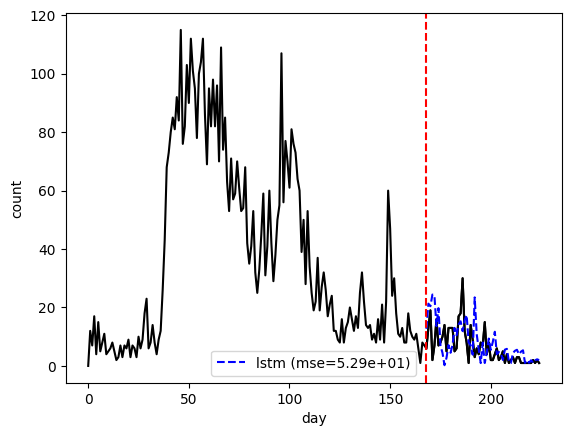

In [13]:
y_given = wave_y.detach().numpy().reshape(-1)
plt.plot(range(len(y_given)), y_given, color='black')
plt.plot(range(TRAIN_RANGE, len(y_given)), y_train_sample, color='black')
plt.plot(range(TRAIN_RANGE, len(y_given)), y_pred_lstm, 'b--', label='lstm (mse={mse:.2e})'.format(mse=mse_lstm))
plt.axvline(x=TRAIN_RANGE, linestyle='--', color='red')
plt.ylabel("count")
plt.xlabel("day")
plt.legend()
plt.show()

In [36]:
list(model.feature_attention.query.parameters())

[Parameter containing:
 tensor([[-1.8952e-01,  2.8366e-01,  1.1762e-01,  7.2259e-01, -1.2933e-01,
          -2.2131e-01,  1.8458e-01, -8.2005e-02, -2.1228e-01, -1.2171e-01,
           3.7736e-01,  2.8979e-01,  4.4910e-01,  2.3753e-01, -1.6876e-01,
          -2.1503e-01,  6.4681e-02,  4.9365e-02, -2.7059e-02, -8.2686e-02],
         [ 5.5198e-03,  1.1392e-01,  4.1953e-02,  5.4684e-01, -1.0847e-01,
          -1.5118e-01,  2.0439e-01, -2.0635e-01, -7.1542e-02, -4.6419e-02,
           3.1878e-01,  3.6131e-01,  3.9915e-01,  3.4734e-01, -3.0235e-02,
          -4.3797e-02,  1.9406e-01,  1.5974e-01, -9.3997e-02, -1.2423e-01],
         [-1.7634e-01, -3.6450e-02, -1.3536e-01,  3.2576e-01, -2.0513e-01,
          -1.6231e-02,  2.9846e-01,  2.1227e-01,  2.0373e-01, -9.9251e-02,
           1.9993e-01,  1.3660e-01,  1.5969e-01,  2.2858e-01, -9.9643e-02,
           1.6123e-01,  1.1686e-01, -4.2295e-01,  1.8046e-01,  1.6196e-01],
         [-5.9736e-02,  1.0778e-01,  2.9144e-01,  3.8343e-01, -1.8362e-01,

In [19]:
x_test.shape

torch.Size([1, 15, 20])

In [32]:
dir(model.feature_attention.query)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per